# Word2Vec 계산요령 - 부정표집

- 목표 단어와 주변 단어들로 이뤄진 하나의 훈련 샘플을 신경망에 입력하면, 신경망의 모든 가중치가 갱신됨.
- 어휘의 모든 단어에 대한 단어 벡터의 성분들이 변하게 됨.
- But, **어휘의 단어가 아주 크다면 커다란 one-hot vector에 대해 모든 가중치를 갱신하는데 시간이 오래 걸림.**

<br>

- 문맥 구간에 포함되지 않은 단어들까지 포함한 모든 단어의 가중치들을 갱신하는 대신,
- **예측 결과가 부정(negative)인 단어들만 가중치 갱신에 사용**하는 방법.
    - 출력 벡터에 기초해 **negative sample n개**를 뽑고, **해당 출력들에 기여한 가중치들을 갱신**.
    - 정확도가 크게 떨어지지 않으면서도 **훈련에 필요한 계산량이 크게 줄어듦.**

## Negative Sampling

<br>

- Word2Vec의 출력층에선 *softmax를 지난 단어 집합 크기의 벡터와 실제 값인 one-hot vector의 오차*를 구하고,
- 이로부터 *임베딩 테이블에 있는 모든 단어에 대한 임베딩 벡터 값을 갱신*함.
- 위에서 설명한 것 처럼, **단어 집합 크기가 커지게 되면 이 작업은 굉장히 무거운 작업**이 됨.
    - 현재 집중하고 있는 중심 단어와 주변 단어가 '강아지', '고양이', '귀여운' 과 같은 단어라면,
    - 이 단어들과 별 연관 관계가 없는 '돈까스', '컴퓨터'와 같은 
    - 수많은 단어의 임베딩 벡터값까지 갱신하는건 비효율적.

<br>

- 네거티브 샘플링은 Word2Vec이 학습과정에서 **전체 단어 집합이 아닌,**
- **일부 단어 집합에만 집중하도록 하는 방법.**
    - 현재 집중하고 있는 주변 단어가 '고양이', '귀여운' 이라고 해보자.
    - 여기에 '돈까스', '컴퓨터', '회의실'과 같은 단어 집합에서 **무작위로 선택된 주변 단어가 아닌 단어들을 일부 가져온다.**
    - 중심 단어에 대해 **전체 단어 집합보다 훨씬 작은 단어 집합을 만들고**, **마지막 단계를 이진 분류 문제로 변환.**
    - **주변 단어들을 positive, 랜덤으로 샘플링 된 단어들을 negative로 라벨링** 한다면
    - **이진 분류 문제를 위한 데이터 셋이 만들어 짐.**
- 기존 단어 집합의 크기만큼의 선택지를 두고, 다중 클래스 분류 문제를 풀던 Word2Vec보다 훨씬 효율적.

## Skip-gram with Negative Sampling, SGNS

<br>

- 기존의 skip-gram은 중심 단어로부터 주변 단어를 예측하는 모델.
- 중심단어를 입력받아, 알고리즘을 거쳐 주변 단어를 출력하는 셈.

<br>

- SGNS는 다른 방법.
- **중심 단어와 주변 단어가 모두 입력**되고, 이 **두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지에 대한 확률을 예측**.

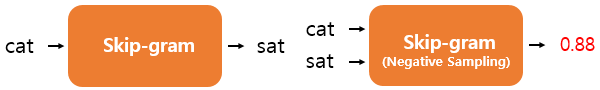

- 2개의 임베딩 층 사용.
    - 한개는 중심 단어의 table lookup을 위한 임베딩 테이블.
    - 한개는 주변 단어의 table lookup을 위한 임베딩 테이블.
- 임베딩 벡터 변환 후, 다음의 연산 수행.
    - 중심 단어와 주변 단어의 내적값을 모델의 예측값으로 설정,
    - label과의 오차로부터 역전파, 
    - 중심단어와 주변 단어의 임베딩 벡터값 갱신

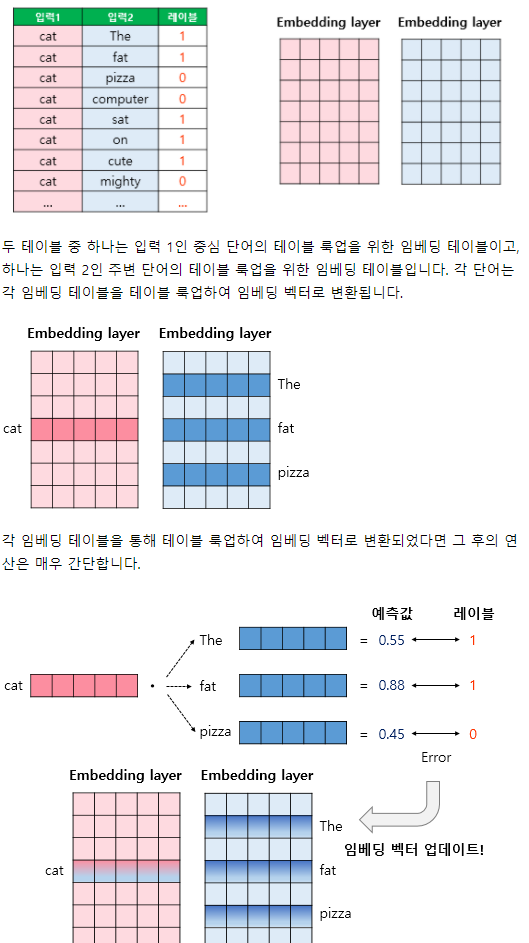



## 20-news group example

<br>

- 하나의 샘플에 최소 단어 2개는 있어야 함. 최소 2-gram.
- 그래야 중심-주변 단어 관계가 성립함. 안그러면 샘플 구성이 안되어서 에러 발생.
- 전처리 과정에서 이를 만족하지 않는 샘플을 제거해줘야 한다.

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
datasets = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = datasets.data
documents[:2]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

In [3]:
print('총 샘플 수 : ', len(documents))

총 샘플 수 :  11314


    불필요한 토큰 제거, 소문자화를 통한 정규화 진행.

In [4]:
news_df = pd.DataFrame({'document':documents})

# 특수문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")

# 길이가 3 이하인 단어 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w 
                                                                      in x.split() if len(w) > 3]))

# 전체 단어 소문자화
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

C:\Users\skdbs\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [5]:
news_df.head()

,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure about story seem biased what disagre...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",yeah expect people read actually accept hard a...
2,Although I realize that principle is not one o...,although realize that principle your strongest...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding legitimate fuss about this pro...
4,"Well, I will have to change the scoring on my ...",well will have change scoring playoff pool unf...


In [6]:
# Null 유무 확인
news_df.isnull().values.any()

False

In [7]:
# 빈(empty) 값은 있는지?
# 빈 값에 대해 NaN을 주고 지우자.
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [9]:
news_df.dropna(inplace=True)
print('총 샘플 수 : ', len(news_df))

총 샘플 수 :  10995


    약 400개 지워짐.

In [10]:
# 불용어 리스트를 통해 불용어 제거.
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()
tokenized_doc[:2]

[['well',
  'sure',
  'story',
  'seem',
  'biased',
  'disagree',
  'statement',
  'media',
  'ruin',
  'israels',
  'reputation',
  'rediculous',
  'media',
  'israeli',
  'media',
  'world',
  'lived',
  'europe',
  'realize',
  'incidences',
  'described',
  'letter',
  'occured',
  'media',
  'whole',
  'seem',
  'ignore',
  'subsidizing',
  'israels',
  'existance',
  'europeans',
  'least',
  'degree',
  'think',
  'might',
  'reason',
  'report',
  'clearly',
  'atrocities',
  'shame',
  'austria',
  'daily',
  'reports',
  'inhuman',
  'acts',
  'commited',
  'israeli',
  'soldiers',
  'blessing',
  'received',
  'government',
  'makes',
  'holocaust',
  'guilt',
  'away',
  'look',
  'jews',
  'treating',
  'races',
  'power',
  'unfortunate'],
 ['yeah',
  'expect',
  'people',
  'read',
  'actually',
  'accept',
  'hard',
  'atheism',
  'need',
  'little',
  'leap',
  'faith',
  'jimmy',
  'logic',
  'runs',
  'steam',
  'sorry',
  'pity',
  'sorry',
  'feelings',
  'denial'

In [11]:
# 단어가 1개 이하인 샘플의 index를 찾아 저장, 해당 샘플 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 : ', len(tokenized_doc))

총 샘플 수 :  10940


    단어 집합 생성 후 정수 인코딩 진행

In [12]:
tokenizer = Tokenizer() # keras tokenizer
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [13]:
# 단어집합 크기 확인
vocab_size = len(word2idx) + 1
print('단어 집합 크기 : ', vocab_size)

단어 집합 크기 :  64277


    64227개의 단어가 존재.

### Negative sampling을 통한 데이터 셋 구성

<br>

- 일반적인 전처리 과정 진행 후, 네거티브 샘플링을 통한 데이터셋 구성이 필요.
- 케라스에서 제공하는 skipgrams 모듈 필요.
    - 시간이 좀 걸림. 상위 10개 샘플에 대해서만 수행.

In [14]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [15]:
# 첫번째 뉴스 그룹 샘플(skip_grams[0])에 대해서만 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
        idx2word[pairs[i][0]], pairs[i][0],
        idx2word[pairs[i][1]], pairs[i][1], labels[i]
    ))

(might (52), sail (6720)) -> 0
(sure (59), well (9)) -> 1
(think (6), whole (217)) -> 1
(europe (1095), lived (1148)) -> 1
(austria (4866), inhuman (10668)) -> 1


    윈도우 크기 내에서 중심단어, 주변단어 관계를 갖는 경우 1의 label 부여
    그렇지 않은 경우엔 0의 label 부여.
    이 과정은 각각의 뉴스 그룹 샘플에 대해 동일한 프로세스로 수행.

In [16]:
# 첫번째 뉴스그룹 샘플에 대해 생긴 pairs와 labels의 개수
len(pairs), len(labels)

(2220, 2220)

In [16]:
# 모든 뉴스그룹 샘플에 대해 수행
# GPU를 씁시다. 왜 메모리 덤프 날까.
import tensorflow as tf

with tf.device('/GPU:0'):
    skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

In [17]:
len(skip_grams)

10940

In [18]:
# 메모리 왜 free를 못할까
import gc
gc.get_count() # 가장 오래된 세대가 696? ㅋㅋㅋㅋ 

(236, 8, 696)

In [19]:
gc.collect()

0

In [20]:
gc.get_count()

(256, 0, 0)

In [21]:
import psutil

p = psutil.Process()
p.memory_info()

pmem(rss=4591607808, vms=4856156160, num_page_faults=9189691, peak_wset=5575282688, wset=4591607808, peak_paged_pool=2034160, paged_pool=2034160, peak_nonpaged_pool=2084624, nonpaged_pool=2082368, pagefile=4856156160, peak_pagefile=6088433664, private=4856156160)

In [22]:
def memory_usage(message: str = 'debug'):
    # current process RAM usage
    p = psutil.Process()
    rss = p.memory_info().rss / 2 ** 20 # Bytes to MB
    print(f"[{message}] memory usage: {rss: 10.5f} MB")

memory_usage('#1')

[#1] memory usage:  4378.91016 MB


### Skip-Gram with Negative Sampling (SGNS) 구현

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [27]:
# 임베딩 벡터 차원 지정.
# 사용자가 지정하는 하이퍼 파라미터.
embed_size = 100

In [28]:
# 2개의 임베딩 테이블 생성 - 중심단어, 주변단어

# 중심단어를 위한 임베딩 태이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size)(w_inputs)

    각 임베딩 테이블은 중심단어-주변단어 각각을 위한 임베딩 테이블.
    각 단어는 임베딩 테이블을 거쳐 내적 수행.
    내적 결과는 1 or 0을 예측하기 위해 sigmoid를 거쳐 최종 예측값을 얻음.

In [29]:
dot_product = Dot(axes=2)([word_embedding, context_embedding]) # 내적 수행
dot_product = Reshape((1, ), input_shape=(1, 1))(dot_product) # 형태 변환
output = Activation('sigmoid')(dot_product) # 출력층

In [30]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       6427700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       6427700     input_1[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1, 1)         0           embedding[0][0]                  
                                                                 embedding_1[0][0]     

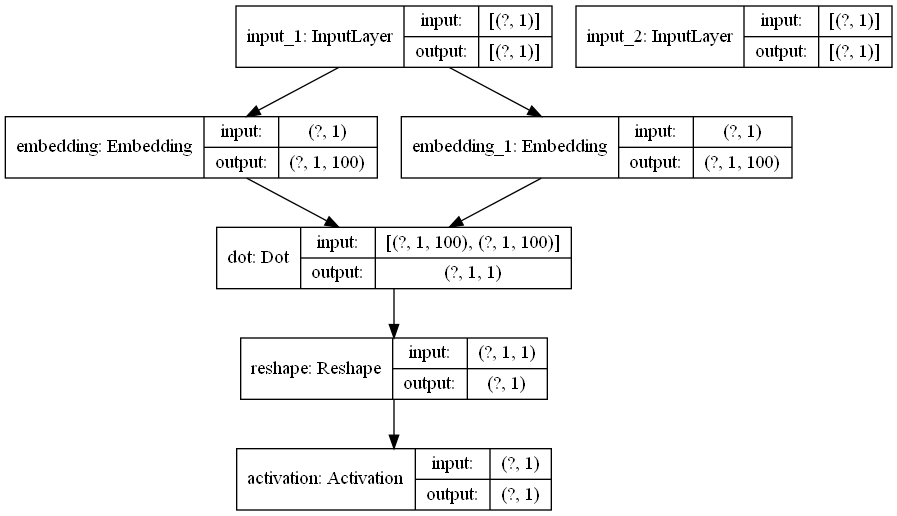

In [31]:
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='SGNS_Model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [33]:
# 학습 수행, 대략 5~10회 정도만 굴려보자.
# GPU 쓰자. 위험한데? 메모리 할당이 안멈춰
# with tf.device('/GPU:0'):
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X, Y)
    print('Epoch : ', epoch, 'Loss : ', loss)

KeyboardInterrupt: 